In [1]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 45.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0, MobileNetV2, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Conv2DTranspose
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
import pathlib
import os
import datetime
import time
import keras_cv
import random
from sklearn.model_selection import train_test_split

In [3]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [4]:
if 'flower_photos' in [item.name for item in data_dir.glob('*')]:
    data_dir = data_dir / 'flower_photos'

flowers_classes = [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]

tulips_dir = data_dir / 'tulips'
tulips_images = list(tulips_dir.glob('*.jpg'))

# 다른 클래스에서 각각 1개의 이미지만 가져오기
other_images = []
for flower_class in flowers_classes:
    if flower_class != 'tulips':
        class_dir = data_dir / flower_class
        image_files = list(class_dir.glob('*.jpg'))
        if image_files:
            other_images.append(image_files[0])  # 각 클래스에서 첫 번째 이미지만 추가

# Validation 데이터셋 생성 (tulips만)
val_tulips_images = tulips_images[:552]  # 0~552번까지
train_tulips_images = tulips_images[552:]  # 553번부터 나머지

# Train 데이터셋 생성 (tulips 나머지 + 다른 클래스 1개씩)
train_image_paths = train_tulips_images + other_images
train_labels = ['tulips'] * len(train_tulips_images) + [flower_class for flower_class in flowers_classes if flower_class != 'tulips']

# Validation 데이터셋 생성 (tulips만)
val_image_paths = val_tulips_images
val_labels = ['tulips'] * len(val_tulips_images)

# 클래스 이름 목록 및 클래스 수
class_names = np.unique(train_labels)
num_classes = len(class_names)

# 이미지 크기 및 배치 설정
img_height = 150
img_width = 150
batch_size = 32

# 데이터 증강 설정 사용x
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# 이미지 경로와 레이블을 이용하여 tf.data.Dataset 생성
def create_dataset(image_paths, labels):
    image_paths = [str(path) for path in image_paths]
    image_ds = tf.data.Dataset.from_tensor_slices(image_paths)
    image_ds = image_ds.map(lambda x: tf.image.decode_jpeg(tf.io.read_file(x), channels=3))
    image_ds = image_ds.map(lambda x: tf.image.resize(x, [img_height, img_width]))

    label_map = {label: index for index, label in enumerate(class_names)}
    numerical_labels = [label_map[label] for label in labels]
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(numerical_labels, tf.int32))

    dataset = tf.data.Dataset.zip((image_ds, label_ds))
    return dataset.batch(batch_size)

# Train 데이터셋 생성
train_ds = create_dataset(train_image_paths, train_labels)

# Validation 데이터셋 생성
val_ds = create_dataset(val_image_paths, val_labels)

# 데이터셋 캐시 및 prefetch
AUTOTUNE = tf.data.AUTOTUNE
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 출력: 데이터셋 정보 확인
print(f"Train dataset size: {len(train_image_paths)} images")
print(f"Validation dataset size: {len(val_image_paths)} images")
print(f"Number of classes: {num_classes}")


Train dataset size: 251 images
Validation dataset size: 552 images
Number of classes: 5


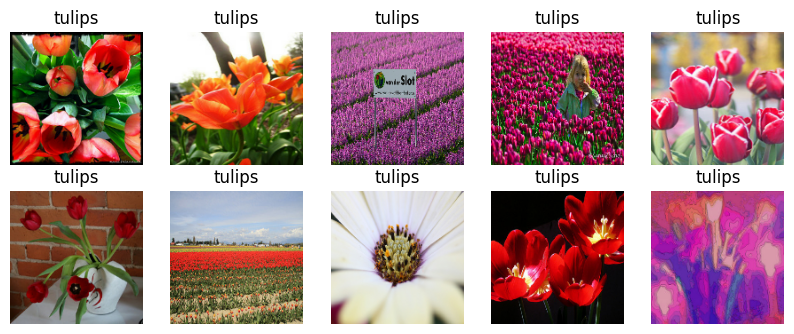

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


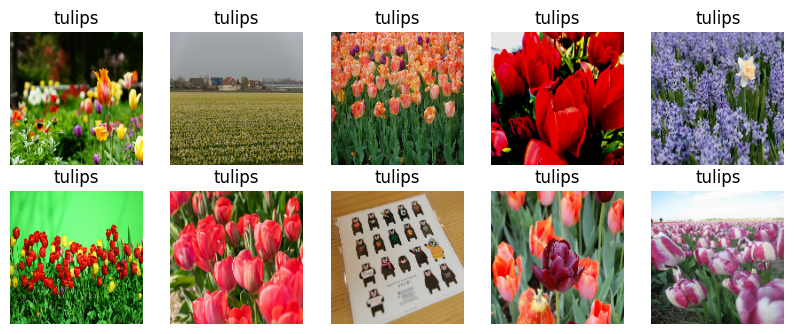

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [7]:
pd.DataFrame(train_labels).value_counts()

,count
0,
tulips,247
daisy,1
dandelion,1
roses,1
sunflowers,1


In [8]:
pd.DataFrame(val_labels).value_counts()

,count
0,
tulips,552


In [9]:
train_count = sum(1 for _ in train_ds.unbatch())
val_count = sum(1 for _ in val_ds.unbatch())

print("Train 데이터 개수:", train_count)
print("Validation 데이터 개수:", val_count)

Train 데이터 개수: 251
Validation 데이터 개수: 552


In [19]:
def build_attention_cnn():
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = normalization_layer(x)
    x = layers.Conv2D(16, 1, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.LayerNormalization()(x)

    # Attention 코드
    x = layers.MaxPooling2D((2, 2))(x)
    shape = tf.keras.backend.int_shape(x)
    x = layers.Reshape((shape[1] * shape[2], shape[3]))(x)
    x = layers.MultiHeadAttention(num_heads=2, key_dim=32)(x, x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_attention_cnn_light():
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = normalization_layer(x)
    x = layers.Conv2D(4, 1, activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.MaxPooling2D((2, 2))(x)
    shape = tf.keras.backend.int_shape(x)
    x = layers.Reshape((shape[1] * shape[2], shape[3]))(x)
    x = layers.MultiHeadAttention(num_heads=1, key_dim=8)(x, x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(8, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_mini_cnn():
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = normalization_layer(x)

    x = layers.Conv2D(4, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(8, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(8, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_tiny_cnn():
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = normalization_layer(x)

    x = layers.Conv2D(2, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(4, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(4, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_micro_cnn():
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)
    x = normalization_layer(x)

    x = layers.Conv2D(1, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


Evaluating and plotting Attention-CNN ...


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 150, 150, 4)    │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 75, 75, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 75, 75, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 8)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525 (2.05 KB)

 Trainable params: 525 (2.05 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - accuracy: 0.9732 - loss: 1.5052 - val_accuracy: 1.0000 - val_loss: 1.4014
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9567 - loss: 1.3833 - val_accuracy: 1.0000 - val_loss: 1.2283
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9856 - loss: 1.1907 - val_accuracy: 1.0000 - val_loss: 0.9966
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9944 - loss: 0.9572 - val_accuracy: 1.0000 - val_loss: 0.7109
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9856 - loss: 0.6926 - val_accuracy: 1.0000 - val_loss: 0.4327
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9944 - loss: 0.4148 - val_accuracy: 1.0000 - val_loss: 0.2312
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9944 - loss: 0.2208 - val_accuracy: 1.0000 - val_loss: 0.1206
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9732 - loss: 0.2139 - val_accuracy: 1.0000 - val_loss: 0.0709


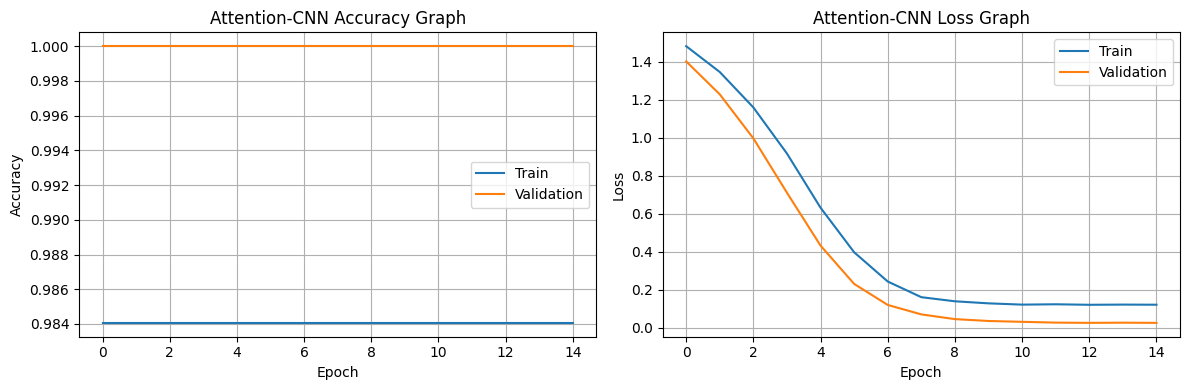

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time


model_builders = {
    "Attention-CNN": build_mini_cnn,
}

results = []
all_results = []
EPOCHS = 15

# 모델별 훈련 및 평가
for name, builder in model_builders.items():
    print(f"Evaluating and plotting {name} ...")
    model = builder()
    model.summary()

    dummy_input = tf.zeros((1, img_height, img_width, 3))
    _ = model(dummy_input)

    total_params = model.count_params()
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])

    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1
    )
    training_time = time.time() - start_time

    model_res = model.evaluate(val_ds, verbose=0)
    test_loss, test_accuracy = model_res[0], model_res[1]

    print(f'{name} 모델 정확률 = {test_accuracy * 100:.2f}%')
    print(f'{name} 모델 파라미터 = {trainable_params:,}')

    # 결과 저장
    all_results.append({
        'model_name': name,
        'test_accuracy': test_accuracy * 100,
        'test_loss': test_loss,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'training_time': training_time
    })

    # 학습 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} Accuracy Graph')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{name} Loss Graph')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.tight_layout()
    plt.show()

Evaluating and plotting Attention-CNN ...


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 150, 150, 1)    │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 75, 75, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38 (152.00 B)

 Trainable params: 38 (152.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9567 - loss: 1.4786 - val_accuracy: 1.0000 - val_loss: 1.3878
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9807 - loss: 1.3887 - val_accuracy: 1.0000 - val_loss: 1.3003
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9892 - loss: 1.3001 - val_accuracy: 1.0000 - val_loss: 1.2167
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9892 - loss: 1.2182 - val_accuracy: 1.0000 - val_loss: 1.1381
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9567 - loss: 1.1654 - val_accuracy: 1.0000 - val_loss: 1.0652
Attention-CNN 모델 정확률 = 100.00%
Attention-CNN 모델 파라미터 = 38


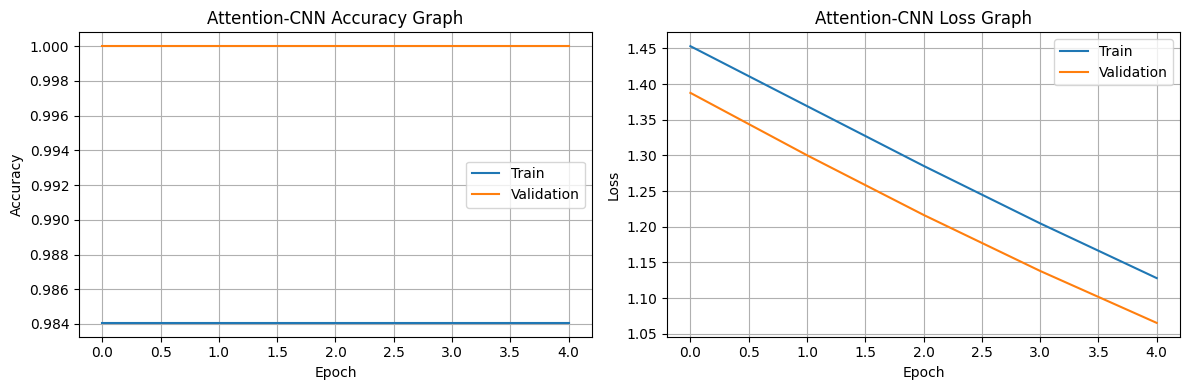

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time


model_builders = {
    "Attention-CNN": build_micro_cnn,
}

results = []
all_results = []
EPOCHS = 5

# 모델별 훈련 및 평가
for name, builder in model_builders.items():
    print(f"Evaluating and plotting {name} ...")
    model = builder()
    model.summary()

    dummy_input = tf.zeros((1, img_height, img_width, 3))
    _ = model(dummy_input)

    total_params = model.count_params()
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])

    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1
    )
    training_time = time.time() - start_time

    model_res = model.evaluate(val_ds, verbose=0)
    test_loss, test_accuracy = model_res[0], model_res[1]

    print(f'{name} 모델 정확률 = {test_accuracy * 100:.2f}%')
    print(f'{name} 모델 파라미터 = {trainable_params:,}')

    # 결과 저장
    all_results.append({
        'model_name': name,
        'test_accuracy': test_accuracy * 100,
        'test_loss': test_loss,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'training_time': training_time
    })

    # 학습 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} Accuracy Graph')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{name} Loss Graph')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.tight_layout()
    plt.show()

In [ ]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame([{
    '모델': r['model_name'],
    '정확도 (%)': r['test_accuracy'],
    '손실': r['test_loss'],
    '총 파라미터 수': r['total_params'],
    '훈련 가능한 파라미터': r['trainable_params'],
    '훈련 시간 (초)': r['training_time']
} for r in all_results])

# 결과 테이블 출력
print("\n모델 성능 비교 테이블:")
print(results_df.to_string(index=False))

# 최적 모델 선정
max_accuracy_model = results_df.loc[results_df['정확도 (%)'].idxmax()]
min_params_model = results_df.loc[results_df['총 파라미터 수'].idxmin()]

print(f"\n모델: {max_accuracy_model['모델']}")
print(f"정확도: {max_accuracy_model['정확도 (%)']:.2f}%")
print(f"총 파라미터 수: {max_accuracy_model['총 파라미터 수']:,}")


모델 성능 비교 테이블:
           모델  정확도 (%)       손실  총 파라미터 수  훈련 가능한 파라미터  훈련 시간 (초)
Attention-CNN    100.0 0.432182       525          525   5.213108

모델: Attention-CNN
정확도: 100.00%
총 파라미터 수: 525
